# Analyzing Nobel Prize Data with SQLAlchemy

This notebook is structured as follows:

- SQL schema definition with SQLModel
- Data ingestion into SQLite
- Data analysis with SQLAlchemy

Installation of dependencies:

In [ ]:
%pip install pydash sqlmodel plotly kaleido

Loading of the raw data from the Nobel Prize API as deeply nested JSON:

In [2]:
import requests

API_URL = "https://api.nobelprize.org/2.1"

r = requests.get(f"{API_URL}/laureates", params={"limit": 2000})
laureates = r.json()["laureates"]

## SQL schema definition with SQLModel

In [3]:
from datetime import date

from pydantic import (
    HttpUrl,
    validator,
)
from sqlalchemy import ForeignKeyConstraint
from sqlmodel import (
    Field,
    Relationship,
    Session,
    SQLModel,
    create_engine,
    select,
)

In the following, we define the SQL schema for the Nobel Prize data with SQLModel.

We define table models for `Laureate`, `Prize`, and `Institution` representing the individual Nobel Laureate or organization, the concrete Nobel Prize awarded to one awardee and the affiliated research institution if applicable.

The `Laureate` table has a one-to-many relationship with the `Prize` table.

The `Prize` table has a many-to-many relationship with the `Institution` table, hence we need to define an intermediate table `InstitutionPrize` to represent this relationship.

The many-to-many nature of this relationship is due to the fact that the Nobel Prize recognized work by one awardee can be affiliated with multiple institutions.

In [4]:
class InstitutionPrize(SQLModel, table=True):
    __table_args__ = (
        ForeignKeyConstraint(
            ["year", "category", "sort_order"],
            ["prize.year", "prize.category", "prize.sort_order"],
        ),
    )

    year: int = Field(primary_key=True)
    category: str = Field(primary_key=True)
    sort_order: int = Field(primary_key=True)
    name: str = Field(foreign_key="institution.name", primary_key=True)


class Laureate(SQLModel, table=True):
    id: int = Field(primary_key=True)
    name: str
    is_person: bool
    gender: str | None = Field(default=None)
    birth_date: date | None = Field(default=None)
    death_date: date | None = Field(default=None)
    birth_city: str | None = Field(default=None)
    birth_country: str | None = Field(default=None)
    wikipedia: HttpUrl | None = Field(default=None)
    prizes: list["Prize"] = Relationship(back_populates="laureate")

    @validator("birth_date", pre=True)
    def catch_invalid_birth_date(cls, v):
        try:
            return date.fromisoformat(v)
        except (ValueError, TypeError):
            return None


class Prize(SQLModel, table=True):
    year: int = Field(primary_key=True)
    category: str = Field(primary_key=True)
    sort_order: int = Field(primary_key=True)
    prize_portion: str
    date_awarded: date | None = Field(default=None)
    prize_status: str
    motivation: str
    laureate_id: int = Field(foreign_key="laureate.id")
    laureate: Laureate = Relationship(back_populates="prizes")
    institutions: list["Institution"] = Relationship(
        back_populates="prizes", link_model=InstitutionPrize
    )


class Institution(SQLModel, table=True):
    name: str = Field(primary_key=True)
    city: str | None = Field(default=None)
    country: str | None = Field(default=None)
    prizes: list[Prize] = Relationship(
        back_populates="institutions", link_model=InstitutionPrize
    )

## Data Ingestion

In [5]:
from pydash import py_

In [6]:
engine = create_engine("sqlite://")
SQLModel.metadata.create_all(engine)

In [7]:
session = Session(engine)

In [8]:
institutions = {}

for laureate in laureates:
    plaureate = py_(laureate)

    if plaureate.has("knownName").value():
        attrs = {
            "name": plaureate.get("knownName.en").value(),
            "is_person": True,
            "gender": plaureate.get("gender").value(),
            "birth_date": plaureate.get("birth.date").value(),
            "death_date": plaureate.get("death.date").value(),
            "birth_city": plaureate.get("birth.place.cityNow.en").value(),
            "birth_country": plaureate.get("birth.place.countryNow.en").value(),
        }
    else:
        attrs = {
            "name": plaureate.get("orgName.en").value(),
            "is_person": False,
        }
    attrs["wikipedia"] = plaureate.get("wikipedia.english").value()

    laureate_orm = Laureate(
        id=plaureate.get("id").to_integer().value(),
        **attrs,
    )
    session.add(laureate_orm)

    for prize in plaureate.get("nobelPrizes").value():
        pprize = py_(prize)

        prize_orm = Prize(
            year=pprize.get("awardYear").value(),
            category=pprize.get("category.en").kebab_case().value(),
            sort_order=pprize.get("sortOrder").value(),
            prize_portion=pprize.get("portion").value(),
            date_awarded=pprize.get("dateAwarded").value(),
            prize_status=pprize.get("prizeStatus").value(),
            motivation=pprize.get("motivation.en").value(),
            laureate=laureate_orm,
        )
        session.add(prize_orm)

        for affiliation in pprize.get("affiliations", []).value():
            institution_name = py_.get(affiliation, "nameNow.en")
            if institution_name in institutions:
                institution_orm = institutions[institution_name]
            else:
                institution_orm = Institution(
                    name=institution_name,
                    city=py_.get(affiliation, "cityNow.en"),
                    country=py_.get(affiliation, "countryNow.en"),
                )
                session.add(institution_orm)
                institutions[institution_name] = institution_orm
            institution_orm.prizes.append(prize_orm)

session.commit()

## Data Exploration

Pandas' `read_sql` function is used to read the results from the database into a DataFrame.

In [9]:
import pandas as pd
from sqlmodel import (
    Integer,
    cast,
    desc,
    distinct,
    func,
    union,
)

### Basic statistical descriptors

In [10]:
select_laureates_count = select(func.count()).select_from(Laureate)

pd.read_sql(
    select(
        select(func.count()).select_from(Prize).scalar_subquery().label("prizes_awarded"),
        select_laureates_count.scalar_subquery().label("laureates"),
        select_laureates_count.where(Laureate.is_person).scalar_subquery().label("person laureates"),
        select_laureates_count.where(Laureate.gender == "female").scalar_subquery().label("female laureates"),
        select(func.count(distinct(Laureate.birth_country))).scalar_subquery().label("birth_countries"),
        select(func.count()).select_from(Institution).scalar_subquery().label("institutions"),
        select(func.count(distinct(Institution.country))).scalar_subquery().label("institution_countries"),
    ),
    engine,
)

,prizes_awarded,laureates,person laureates,female laureates,birth_countries,institutions,institution_countries
0,1000,992,965,64,85,348,25


### Oldest and youngest Nobel Laureates

In [11]:
col_age_at_prize_award = Prize.date_awarded - Laureate.birth_date

query_laureate_age_at_prize_award = (
    select(
        Laureate.name,
        Prize.year,
        Prize.category,
        col_age_at_prize_award.label("age_at_prize_award"),
    )
    .join(Laureate.prizes)
    .where(Laureate.is_person)
)

subq_base = query_laureate_age_at_prize_award.subquery()

subq_min = (
    select(func.min(subq_base.c.age_at_prize_award)).select_from(subq_base)
).scalar_subquery()

subq_max = (
    select(func.max(subq_base.c.age_at_prize_award)).select_from(subq_base)
).scalar_subquery()

pd.read_sql(
    union(
        query_laureate_age_at_prize_award.where(col_age_at_prize_award == subq_min),
        query_laureate_age_at_prize_award.where(col_age_at_prize_award == subq_max),
    )
    .order_by("age_at_prize_award"),
    engine,
)

,name,year,category,age_at_prize_award
0,Malala Yousafzai,2014,peace,17
1,John B. Goodenough,2019,chemistry,97


### Multiple Nobel Prize winners

In [12]:
query_multiple_awarded_laureate_ids = (
    select(Prize.laureate_id)
    .group_by(Prize.laureate_id)
    .having(func.count() > 1)
)

pd.read_sql(
    select(Laureate.name, Prize.year, Prize.category)
    .join(Laureate.prizes)
    .where(Laureate.is_person)
    .where(Laureate.id.in_(query_multiple_awarded_laureate_ids))
    .order_by(Prize.year, Prize.category),
    engine,
)

,name,year,category
0,Marie Curie,1903,physics
1,Marie Curie,1911,chemistry
2,Linus Pauling,1954,chemistry
3,John Bardeen,1956,physics
4,Frederick Sanger,1958,chemistry
5,Linus Pauling,1962,peace
6,John Bardeen,1972,physics
7,Frederick Sanger,1980,chemistry
8,K. Barry Sharpless,2001,chemistry
9,K. Barry Sharpless,2022,chemistry


In [13]:
pd.read_sql(
    select(Laureate.name, Prize.year, Prize.category)
    .join(Laureate.prizes)
    .where(Laureate.is_person == False)
    .where(Laureate.id.in_(query_multiple_awarded_laureate_ids))
    .order_by(Prize.year, Prize.category),
    engine,
)

,name,year,category
0,International Committee of the Red Cross,1917,peace
1,International Committee of the Red Cross,1944,peace
2,Office of the United Nations High Commissioner...,1954,peace
3,International Committee of the Red Cross,1963,peace
4,Office of the United Nations High Commissioner...,1981,peace


### Affiliated institutions with most Nobel Prizes

In [14]:
institutions_by_laureates = pd.read_sql(
    select(Institution, func.count().label("laureate_count"))
    .join(Institution.prizes)
    .join(Prize.laureate)
    .where(Laureate.is_person)
    .group_by(Institution.name)
    .order_by(desc("laureate_count")),
    engine,
)

institutions_by_laureates.head(10)

,name,city,country,laureate_count
0,University of California,"Santa Barbara, CA",USA,39
1,Harvard University,"Cambridge, MA",USA,29
2,Massachusetts Institute of Technology (MIT),"Cambridge, MA",USA,23
3,Stanford University,"Stanford, CA",USA,22
4,California Institute of Technology (Caltech),"Pasadena, CA",USA,20
5,University of Chicago,"Chicago, IL",USA,19
6,University of Cambridge,Cambridge,United Kingdom,18
7,Columbia University,"New York, NY",USA,18
8,Princeton University,"Princeton, NJ",USA,17
9,Howard Hughes Medical Institute,None,USA,15


### Countries with most Nobel Laureates

In [15]:
institution_countries_by_laureates = pd.read_sql(
    select(Institution.country, func.count().label("laureate_count"))
    .join(Institution.prizes)
    .join(Prize.laureate)
    .where(Laureate.is_person)
    .group_by(Institution.country)
    .order_by(desc("laureate_count")),
    engine,
)

institution_countries_by_laureates.head(10)

,country,laureate_count
0,USA,428
1,United Kingdom,98
2,Germany,85
3,France,45
4,Switzerland,25
5,Japan,22
6,Sweden,18
7,Russia,15
8,the Netherlands,10
9,Denmark,10


In [16]:
birth_countries_by_laureates = pd.read_sql(
    select(Laureate.birth_country, func.count().label("laureate_count"))
    .where(Laureate.is_person)
    .group_by(Laureate.birth_country)
    .order_by(desc("laureate_count")),
    engine,
)

birth_countries_by_laureates.head(10)

,birth_country,laureate_count
0,USA,289
1,United Kingdom,89
2,Germany,84
3,France,61
4,Sweden,30
5,Russia,29
6,Poland,28
7,Japan,28
8,Canada,21
9,Italy,20


In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.options.plotting.backend = "plotly"

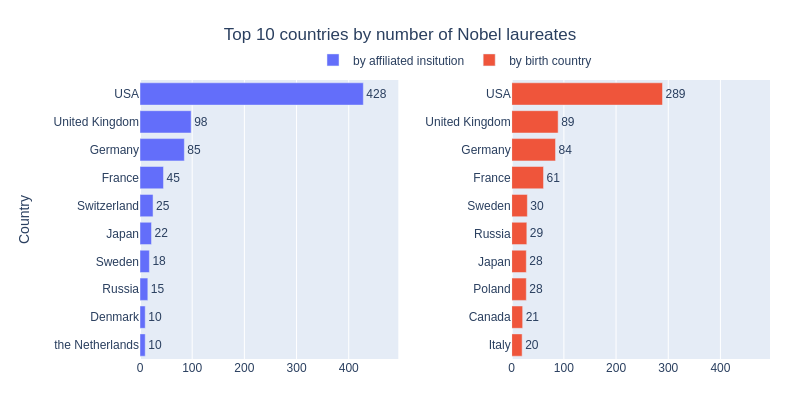

In [22]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.18)

by_institution = institution_countries_by_laureates.head(10).sort_values(by=["laureate_count"], ascending=True)
by_birth_country = birth_countries_by_laureates.head(10).sort_values(by=["laureate_count"], ascending=True)

fig.add_trace(
    go.Bar(
        x=by_institution.laureate_count,
        y=by_institution.country,
        orientation="h",
        name="by affiliated insitution",
        text=by_institution.laureate_count,
        textposition="outside",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Bar(
        x=by_birth_country.laureate_count,
        y=by_birth_country.birth_country,
        orientation="h",
        name="by birth country",
        text=by_birth_country.laureate_count,
        textposition="outside",
    ),
    row=1,
    col=2,
)

fig.update_layout(
    title_text="Top 10 countries by number of Nobel laureates",
    autosize=False,
    width=800,
    height=400,
    title_x=0.5,
    xaxis_title="",
    yaxis_title="Country",
    margin=dict(l=140, r=30, t=80, b=0),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=.5),
)
fig.update_xaxes(range=[0, 495])

fig.show("png")

In [19]:
session.close()